
## 项目 2: 预测波士顿房价



---
## 第一步. 导入数据
此项目的数据集来自[UCI库(数据集已下线)](https://archive.ics.uci.edu/ml/datasets.html)。波士顿房屋这些数据于1978年开始统计，共506个数据点，涵盖了麻省波士顿不同郊区房屋14种特征的信息。本项目对原始数据集做了以下处理：
- 有16个`'MEDV'` 值为50.0的数据点被移除。 这很可能是由于这些数据点包含**遗失**或**看不到的值**。
- 有1个数据点的 `'RM'` 值为8.78. 这是一个异常值，已经被移除。
- 对于本项目，房屋的`'RM'`， `'LSTAT'`，`'PTRATIO'`以及`'MEDV'`特征是必要的，其余不相关特征已经被移除。
- `'MEDV'`特征的值已经过必要的数学转换，可以反映35年来市场的通货膨胀效应。



In [28]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


---
## 第二步. 分析数据
在项目的第一个部分会对波士顿房地产数据进行初步的观察和分析。

由于这个项目的最终目标是建立一个预测房屋价值的模型，我们需要将数据集分为**特征(features)**和**目标变量(target variable)**。
- **特征** `'RM'`， `'LSTAT'`，和 `'PTRATIO'`，给我们提供了每个数据点的数量相关的信息。
- **目标变量**：` 'MEDV'`，是我们希望预测的变量。

他们分别被存在 `features` 和 `prices` 两个变量名中。


1. 计算 `prices` 中的 `'MEDV'` 的最小值、最大值、均值、中值和标准差；
2. 将运算结果储存在相应的变量中。

In [29]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:.2f}".format(minimum_price)) 
print("Maximum price: ${:.2f}".format(maximum_price))
print("Mean price: ${:.2f}".format(mean_price))
print("Median price ${:.2f}".format(median_price))
print("Standard deviation of prices: ${:.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.00
Maximum price: $1024800.00
Mean price: $454342.94
Median price $438900.00
Standard deviation of prices: $165171.13


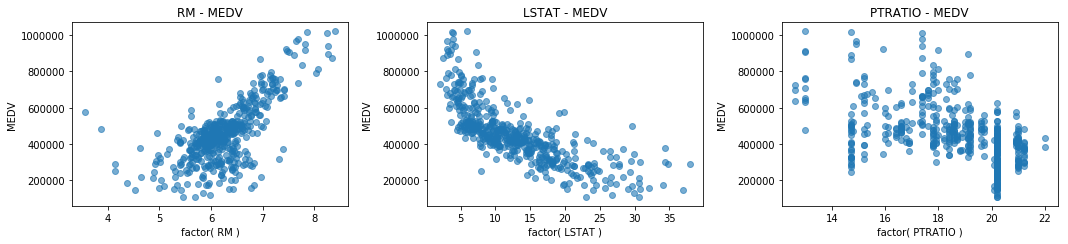

In [30]:
import matplotlib.pyplot as plt

dataset = ['RM', 'LSTAT', 'PTRATIO']
# 设定画图板尺寸
plt.figure(figsize=(15, 3.5))
for i, key in enumerate(dataset):
    # 设定子图，将每个子图输出到对应的位置,1行3列i+1依次排列
    plt.subplot(1,3,1+i)
    plt.title(key + ' - MEDV')
    plt.xlabel('factor( ' + key + ' )')
    plt.ylabel('MEDV')
    # 调整每隔子图之间的距离
    plt.tight_layout()
    plt.scatter(data[key], data['MEDV'], alpha = 0.6)

---
## 第三步. 建立模型


### 定义衡量标准
如果不能对模型的训练和测试的表现进行量化地评估，我们就很难衡量模型的好坏。通常我们会定义一些衡量标准，这些标准可以通过对某些误差或者拟合程度的计算来得到。在这个项目中，通过运算[决定系数](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ 来量化模型的表现。模型的决定系数是回归分析中十分常用的统计信息，经常被当作衡量模型预测能力好坏的标准。

$R^2$ 的数值范围从0至1，表示**目标变量**的预测值和实际值之间的相关程度平方的百分比。一个模型的 $R^2$ 值为0还不如直接用**平均值**来预测效果好；而一个 $R^2$ 值为1的模型则可以对目标变量进行完美的预测。从0至1之间的数值，则表示该模型中目标变量中有百分之多少能够用**特征**来解释。模型也可能出现负值的 $R^2$，这种情况下模型所做预测有时会比直接计算目标变量的平均值差很多。


In [31]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [32]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


### 数据分割与重排
接下来，把波士顿房屋数据集分成训练和测试两个子集。通常在这个过程中，数据也会被重排列，以消除数据集中由于顺序而产生的偏差。
在下面的代码中，

* 使用 `sklearn.model_selection` 中的 `train_test_split`， 将 `features` 和 `prices` 的数据都分成用于训练的数据子集和用于测试的数据子集。
  - 分割比例为：80%的数据用于训练，20%用于测试；
  - 选定一个数值以设定 `train_test_split` 中的 `random_state` ，这会确保结果的一致性；
* 将分割后的训练集与测试集分配给 `X_train`, `X_test`, `y_train` 和 `y_test`。

In [33]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=5)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### 学习曲线
下方区域内的代码会输出四幅图像，它们是一个决策树模型在不同最大深度下的表现。每一条曲线都直观得显示了随着训练数据量的增加，模型学习曲线的在训练集评分和验证集评分的变化，评分使用决定系数 $R^2$。曲线的阴影区域代表的是该曲线的不确定性（用标准差衡量）。

运行下方区域中的代码，并利用输出的图形回答下面的问题。

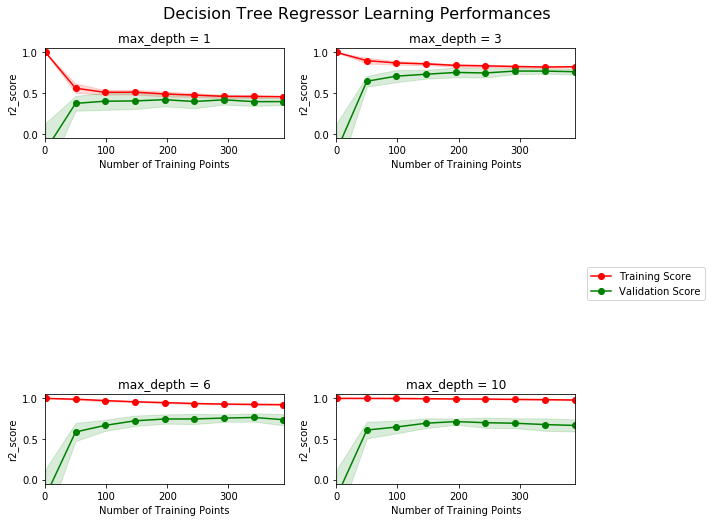

In [34]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### 复杂度曲线
下列代码内的区域会输出一幅图像，它展示了一个已经经过训练和验证的决策树模型在不同最大深度条件下的表现。这个图形将包含两条曲线，一个是训练集的变化，一个是验证集的变化。跟**学习曲线**相似，阴影区域代表该曲线的不确定性，模型训练和测试部分的评分都用的 `performance_metric` 函数。



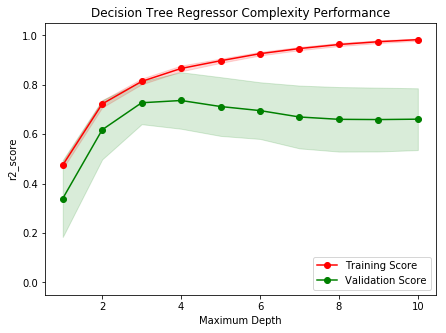

In [35]:
vs.ModelComplexity(X_train, y_train)

---
## 第四步. 评估模型的表现
在项目的最后一节中，你将构建一个模型，并使用 `fit_model` 中的优化模型去预测客户特征集。

In [36]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
    
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

## 第五步. 做出预测
当我们用数据训练出一个模型，它现在就可用于对新的数据进行预测。在决策树回归函数中，模型已经学会对新输入的数据*提问*，并返回对**目标变量**的预测值。你可以用这个预测来获取数据未知目标变量的信息，这些数据必须是不包含在训练数据之内的。



将决策树回归函数代入训练数据的集合，以得到最优化的模型。

In [37]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


In [38]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $411,931.58
Predicted selling price for Client 2's home: $235,620.00
Predicted selling price for Client 3's home: $922,740.00



1. 客户1：411,932。该价格位于客户2和3之间，与特征数据吻合，价格合理
2. 客户2：235,620。贫困指数最高，房间数最少，价格最低，合理。
3. 客户3：922,740。贫困指数最低，房间数最高，价格最高，合理。

使用最优模型在整个测试数据上进行预测, 并计算相对于目标变量的决定系数 $R^2$ 的值。




In [39]:
# Calculate the r2 score between 'y_true' and 'y_predict'

predicted = reg.predict(X_test)
r2 = performance_metric(y_test, predicted)

print("Optimal model has R^2 score {:,.2f} on test data".format(r2))

Optimal model has R^2 score 0.85 on test data



决定系数值为：0.85，预测表现良好，模型准确度有待提高。

In [40]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $390,250.00
Trial 8: $414,430.43
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $30,372.22
